In [1]:
#To generate GIFs
#!pip install imageio
#!pip install git+https://github.com/tensorflow/docs
#!pip install tqdm

import sys
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from keras.datasets import mnist
from IPython import display
from datetime import datetime
#from tqdm import tqdm

import keras
from keras.models import Model

#import tensorflow_docs.vis.embed as embed


#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import roc_curve, auc
#import seaborn as sns
#from sklearn.metrics import accuracy_score

print(sys.prefix,sys.version)

2024-05-31 12:46:17.256033: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 12:46:20.672825: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 12:46:20.685349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 12:46:25.209015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/anaconda/envs/ML2_env 3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [2]:
# Ensure TensorFlow is set up to use the GPU if available
gpus = tf.config.list_physical_devices('GPU')
print("List of GPUs:",gpus)
if gpus:
    print("GPU is available and will be used for generation.")
    device_name = '/GPU:0'
    print("CUDA Support:", tf.test.is_built_with_cuda())
else:
    print("GPU is not available. Ensure you have a compatible GPU and TensorFlow setup.")
    device_name = '/CPU:0'

List of GPUs: []
GPU is not available. Ensure you have a compatible GPU and TensorFlow setup.


2024-05-31 12:46:40.539567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Import & prep dataset

Training data shape:
 (60000, 28, 28, 1) 

Test data shape:
 (10000, 28, 28, 1) 

Training labels shape:
 (60000, 10) 

Test labels shape:
 (10000, 10)


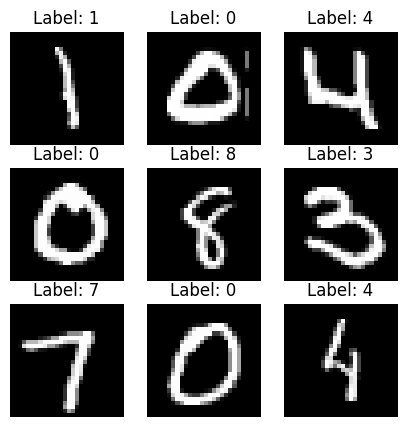

In [3]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

print("Training data shape:\n", train_data.shape, "\n")
print("Test data shape:\n", test_data.shape, "\n")
 
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
 
train_data = (train_data - 127.5) / 127.5  # Normalize the images to [-1, 1]
test_data = (test_data - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

print("Training labels shape:\n", train_labels.shape, "\n")
print("Test labels shape:\n", test_labels.shape)

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

random_indices = np.random.choice(train_data.shape[0], 9, replace=False)
random_digits = train_data[random_indices]

plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_digits[i], cmap='gray')
    plt.title(f"Label: {np.argmax(train_labels[random_indices[i]])}")
    plt.axis('off')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

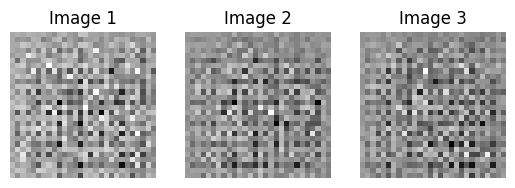

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()
generator.summary()
print("\n\n\n")

#plt.suptitle("Generated Images", fontsize=14)  
for i in range(3):
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    plt.subplot(1, 3, i+1)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')
#plt.tight_layout()
plt.show()

Discriminator: Hier kann ein aufwändiges CNN rein. 

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

decision = discriminator(generated_image)
print("\n\n\n")
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    generator_losses = []
    discriminator_losses = []

    for epoch in range(epochs):
        start = time.time()
        print(f'Epoch {epoch + 1}/{epochs}')

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            generator_losses.append(gen_loss)
            discriminator_losses.append(disc_loss)

        # Produce images and plot losses at the end of each epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        plot_loss(generator_losses, discriminator_losses)

        print('Time for epoch {} is {:.1f} sec'.format(epoch + 1, time.time()-start))

    # Generate and plot images after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    plot_loss(generator_losses, discriminator_losses)
    plt.savefig('losses.svg', format='svg', bbox_inches='tight')

def plot_loss(generator_losses, discriminator_losses):
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.show()

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 256, cmap='gray')
        plt.axis('off')

    plt.savefig('MNIST_gif/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Time for epoch 50 is 158.29893231391907 sec


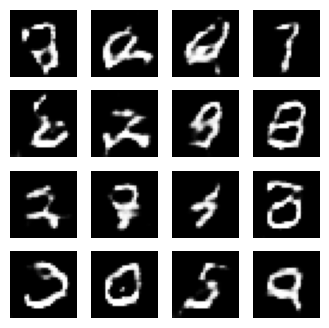

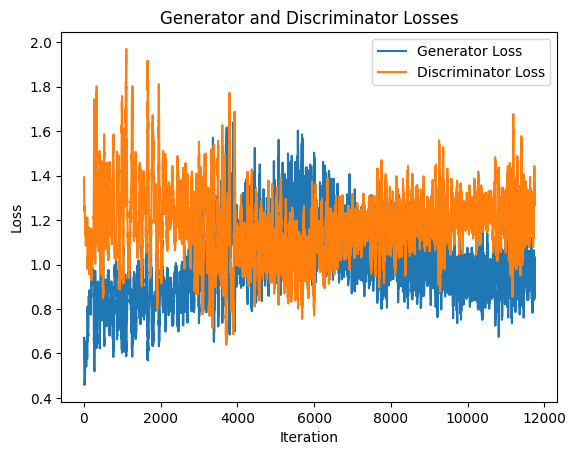

In [7]:
train(train_dataset, EPOCHS)

# Backup the generator and discriminator models
generator.save('MNIST_backups/MNIST_generator_model_{}epochs_backup_{}.keras'.format(EPOCHS, datetime.now()))
discriminator.save('MNIST_backups/MNIST_discriminator_model_{}epochs_backup_{}.keras'.format(EPOCHS, datetime.now()))

# Save the generator model for further processing
generator.save('MNIST_generator_model_{}epochs.keras'.format(EPOCHS))

Saved 50000 generated MNIST digits to MNIST_generated_data/GAN_output_MNIST_50000.npy
Shape of the saved dataset: (50000, 28, 28, 1)


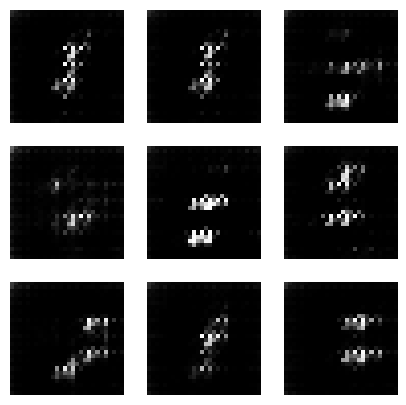

In [8]:
#Load generator from folder
generator = tf.keras.models.load_model('MNIST_generator_model_50epochs.keras')

# Define the number of new MNIST digits to generate
n = 50000  # You can change this number as needed

# Generate random noise to feed into the generator
random_noise = tf.random.normal([n, noise_dim])

# Generate images from the noise
generated_images = generator(random_noise, training=False)

# Rescale the images from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2.0

# Create the directory if it does not exist
output_dir = 'MNIST_generated_data'

# Save the generated images as a NumPy array
output_path = os.path.join(output_dir, f'GAN_output_MNIST_{n}.npy')
np.save(output_path, generated_images.numpy())

print(f'Saved {n} generated MNIST digits to {output_path}')
print(f'Shape of the saved dataset: {generated_images.shape}')

generated_images = np.load(output_path)

random_indices = np.random.choice(generated_images.shape[0], 9, replace=False)
random_digits = generated_images[random_indices]

# Plot the random images
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_digits[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

